<a href="https://colab.research.google.com/github/liadekel/analyzing-big-data/blob/master/HW_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework Assignment  5

**Question 1:** Select a directed network, and develop a simple
    link prediction classifier based on the network's directed topology (40pt). 
    Use node or link embedding features and try to improve the classification (20pt)
    
**Bonus:** Evaluate the classifier's ability to predict future links (10pt)
    
** Note:** You can use [Reddit community networks](http://dynamics.cs.washington.edu/data.html), or search
for networks using [The Colorado Index of Complex Networks](https://icon.colorado.edu/).

In [1]:
!pip install turicreate
!pip install networkx
!pip install tqdm


     |████████████████████████████████| 91.8MB 92kB/s 
     |████████████████████████████████| 86.3MB 95kB/s 
     |████████████████████████████████| 3.4MB 44.8MB/s 
     |████████████████████████████████| 327kB 46.8MB/s 
     |████████████████████████████████| 3.8MB 42.1MB/s 
     |████████████████████████████████| 450kB 48.1MB/s 
  Created wheel for resampy: filename=resampy-0.2.1-cp36-none-any.whl size=320850 sha256=7cd9c1cdbd0ae33381079c53651e8a26dafb47e09a53c1865e431ccdf90403ba
  Stored in directory: /root/.cache/pip/wheels/ff/4f/ed/2e6c676c23efe5394bb40ade50662e90eb46e29b48324c5f9b
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=2e936cb14bf86211995531b519f241e89594a8de4e001c928eb41a384ec83434
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built resampy gast
ERROR: tensorflow-probability 0.10.0rc0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
 

In [0]:
! mkdir ./datasets/

In [36]:
!wget --directory-prefix ./datasets/brain https://s3.amazonaws.com/connectome-graphs/fly/drosophila_medulla_1.graphml

--2020-05-06 17:19:58--  https://s3.amazonaws.com/connectome-graphs/fly/drosophila_medulla_1.graphml
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.39.14
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.39.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11788629 (11M) [binary/octet-stream]
Saving to: ‘./datasets/brain/drosophila_medulla_1.graphml’

drosophila_medulla_ 100%[===================>]  11.24M  6.14MB/s    in 1.8s    

2020-05-06 17:20:01 (6.14 MB/s) - ‘./datasets/brain/drosophila_medulla_1.graphml’ saved [11788629/11788629]



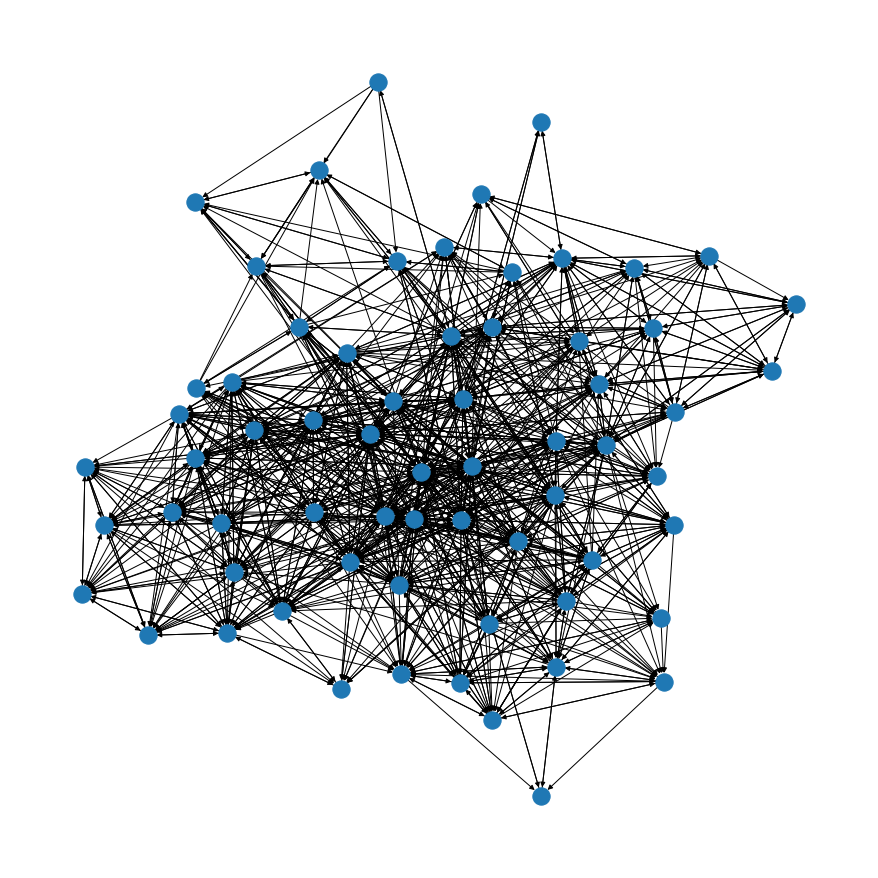

In [102]:
import os
import json
import turicreate as tc
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

BRAIN_DS_FILE = "./datasets/brain/mixed.species_brain_1.graphml"

# load dataset
g = nx.read_graphml(BRAIN_DS_FILE)
plt.figure(figsize=(12,12))
nx.draw_kamada_kawai(g)

In [0]:
import random 

def select_random_existing_links(g, n):
    l =list(g.edges())
    random.shuffle(l)
    return l[:n]

def select_random_non_existing_links(g, n):
    select_links = set()
    v_list = list(g.nodes())
    while len(select_links) < n:
        u = random.choice(v_list)
        v = random.choice(v_list)
        if g.has_edge(u,v) or (u,v) in select_links and u == v:
            continue
        else:
            select_links.add((u,v))
    return list(select_links)
            
    
postive_links = select_random_existing_links(g,1000)
negative_links = select_random_non_existing_links(g,1000)

In [0]:
import operator
def find_friends_of_friends(g, v):
    "Returns a set with all the friends of friends of v that are not friends of v"
    friends_set = set(g.neighbors(v))
    friends_of_friends_set = set()
    for f in friends_set:
        friends_of_friends_set |= set(g.neighbors(f))
    friends_of_friends_set -= friends_set
    friends_of_friends_set -= {v}
    return friends_of_friends_set


def rank_friends_of_friends(g, v):
    rank_dict = {}
    vertices_set = find_friends_of_friends(g, v)
    for u in vertices_set:
        rank_dict[u] = len(common_friends(g, v, u))
    sorted_d = sorted(rank_dict.items(), key=operator.itemgetter(1), reverse=True)
    return sorted_d

In [106]:
from tqdm import tqdm_notebook as tqdm 

def friends_measure(g, u,v):
    s = 0
    for x in find_friends_of_friends(g,u):
        for y in find_friends_of_friends(g,v):
            if g.has_edge(x,y) or x == y:
                s += 1
    return s

def common_friends(g,u,v):
    if not g.has_node(u) or not g.has_node(v):
        return None
    return set(g.neighbors(u)) & set(g.neighbors(v))

def total_friends(g, u, v):   
    return len(set(g.neighbors(v)) | set(g.neighbors(u)))

def get_features_dict(g,u, v):
    removed_edge = False
    if g.has_edge(u,v):
        g.remove_edge(u,v) #  remove edge before feature calculation
        removed_edge = True
    try:
        d = {
            'degree_v': len(list(g.neighbors(v))),
            'degree_u': len(list(g.neighbors(u))),
            'total_friends': total_friends(g,u,v),
            'common_friends': len(common_friends(g,u,v)),
            # 'jaccard_coefficient': list(nx.jaccard_coefficient(g,[(u,v)]))[0][2],
            # 'adamic_adar_index': list(nx.adamic_adar_index(g,[(u,v)]))[0][2],
            # 'friends_measure': friends_measure(g, u,v)
        }
    except:
        if removed_edge:
            g.add_edge(u,v) # return the edge back to the graph
        return None

    
    if removed_edge:
        g.add_edge(u,v) # return the edge back to the graph
    return d

links_features = []

for i in tqdm(range(len(postive_links))):    
    u,v = postive_links[i]
    d = get_features_dict(g, u,v )
    if d is None:
        continue
    d['class'] = True
    links_features.append(d)

for i in tqdm(range(len(negative_links))):    
    u,v = negative_links[i]
    d = get_features_dict(g, u,v )
    if d is None:
        continue
    d['class'] = False
    links_features.append(d)

links_features[0]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:46: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:54: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


{'class': True,
 'common_friends': 9,
 'degree_u': 29,
 'degree_v': 16,
 'total_friends': 36}

In [107]:
features_list = ['degree_v', 'degree_u', 'total_friends', 'common_friends', 'class']
data_dict = {f:[] for f in features_list}
 

for d in links_features:
    for feature in features_list:
        data_dict[feature].append(d[feature])
sf = tc.SFrame(data_dict)
sf

class,common_friends,degree_u,degree_v,total_friends
1,9,29,16,36
1,11,12,16,17
1,8,29,16,37
1,6,31,9,34
1,18,31,30,43
1,16,27,36,47
1,11,15,24,28
1,21,43,31,53
1,5,10,23,28
1,8,10,14,16


In [108]:
test, train  = sf.random_split(0.2)
print(f"Train size {len(train)}\nTest size: {len(test)}" )
features_list = ['degree_v', 'degree_u', 'total_friends', 'common_friends']
cls = tc.classifier.create(train,features=features_list, target="class")

Train size 1607
Test size: 393
PROGRESS: Creating a validation set from 5 percent of training data. This may take a while.
          You can set ``validation_set=None`` to disable validation tracking.

PROGRESS: The following methods are available for this type of problem.
PROGRESS: BoostedTreesClassifier, RandomForestClassifier, DecisionTreeClassifier, SVMClassifier, LogisticClassifier
PROGRESS: The returned model will be chosen according to validation accuracy.


Boosted trees classifier:

--------------------------------------------------------

Number of examples          : 1526

Number of classes           : 2

Number of feature columns   : 4

Number of unpacked features : 4

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| Iteration | Elapsed Time | Training Accuracy | Validation Accuracy | Training Log Loss | Validation Log Loss |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| 1         | 0.014926     | 0.846658          | 0.765432            | 0.563012          | 0.597564            |

| 2         | 0.018514     | 0.849934          | 0.753086            | 0.489799          | 0.559846            |

| 3         | 0.022102     | 0.853211          | 0.740741            | 0.440853          | 0.545557            |

| 4         | 0.025678     | 0.853866          | 0.740741            | 0.408053          | 0.541717            |

| 5         | 0.028900     | 0.854522          | 0.740741            | 0.381832          | 0.542399            |

| 10        | 0.051062     | 0.884666          | 0.777778            | 0.300887          | 0.523338            |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

Random forest classifier:

--------------------------------------------------------

Number of examples          : 1526

Number of classes           : 2

Number of feature columns   : 4

Number of unpacked features : 4

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| Iteration | Elapsed Time | Training Accuracy | Validation Accuracy | Training Log Loss | Validation Log Loss |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| 1         | 0.011424     | 0.832241          | 0.703704            | 0.419079          | 0.556816            |

| 2         | 0.015998     | 0.828965          | 0.679012            | 0.418018          | 0.564798            |

| 3         | 0.019596     | 0.834207          | 0.753086            | 0.418693          | 0.516173            |

| 4         | 0.024129     | 0.832896          | 0.728395            | 0.415894          | 0.522723            |

| 5         | 0.027125     | 0.844037          | 0.740741            | 0.411697          | 0.522694            |

| 10        | 0.041961     | 0.845347          | 0.740741            | 0.410085          | 0.521636            |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

Decision tree classifier:

--------------------------------------------------------

Number of examples          : 1526

Number of classes           : 2

Number of feature columns   : 4

Number of unpacked features : 4

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| Iteration | Elapsed Time | Training Accuracy | Validation Accuracy | Training Log Loss | Validation Log Loss |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| 1         | 0.012748     | 0.846658          | 0.765432            | 0.407453          | 0.527808            |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

SVM:

--------------------------------------------------------

Number of examples          : 1526

Number of classes           : 2

Number of feature columns   : 4

Number of unpacked features : 4

Number of coefficients    : 5

Starting L-BFGS

--------------------------------------------------------

+-----------+----------+-----------+--------------+-------------------+---------------------+

| Iteration | Passes   | Step size | Elapsed Time | Training Accuracy | Validation Accuracy |

+-----------+----------+-----------+--------------+-------------------+---------------------+

| 0         | 5        | 2.000000  | 0.004716     | 0.505242          | 0.506173            |

| 1         | 7        | 2.000000  | 0.006814     | 0.792923          | 0.777778            |

| 2         | 10       | 1.202005  | 0.009653     | 0.763434          | 0.703704            |

| 3         | 11       | 1.202005  | 0.010993     | 0.626474          | 0.629630            |

| 4         | 18       | 2.051565  | 0.016040     | 0.769987          | 0.753086            |

| 9         | 28       | 0.668510  | 0.026622     | 0.794889          | 0.753086            |

+-----------+----------+-----------+--------------+-------------------+---------------------+

Logistic regression:

--------------------------------------------------------

Number of examples          : 1526

Number of classes           : 2

Number of feature columns   : 4

Number of unpacked features : 4

Number of coefficients      : 5

Starting Newton Method

--------------------------------------------------------

+-----------+----------+--------------+-------------------+---------------------+

| Iteration | Passes   | Elapsed Time | Training Accuracy | Validation Accuracy |

+-----------+----------+--------------+-------------------+---------------------+

| 1         | 2        | 0.003788     | 0.777851          | 0.753086            |

| 2         | 3        | 0.007155     | 0.790301          | 0.753086            |

| 3         | 4        | 0.010433     | 0.790301          | 0.753086            |

| 4         | 5        | 0.013486     | 0.790301          | 0.765432            |

| 5         | 6        | 0.016398     | 0.790301          | 0.765432            |

+-----------+----------+--------------+-------------------+---------------------+

SUCCESS: Optimal solution found.

PROGRESS: Model selection based on validation accuracy:
PROGRESS: ---------------------------------------------
PROGRESS: BoostedTreesClassifier          : 0.7777777777777778
PROGRESS: RandomForestClassifier          : 0.7407407407407407
PROGRESS: DecisionTreeClassifier          : 0.7654320987654321
PROGRESS: SVMClassifier                   : 0.7530864197530864
PROGRESS: LogisticClassifier              : 0.7654320987654321
PROGRESS: ---------------------------------------------
PROGRESS: Selecting BoostedTreesClassifier based on validation set performance.


In [74]:
!pip install karateclub

     |████████████████████████████████| 1.8MB 5.8MB/s 
  Created wheel for karateclub: filename=karateclub-1.0.2-cp36-none-any.whl size=63926 sha256=f4347785682d07bf5b06ef447b3437d7088f233df618f860da59b7267495b6f8
  Stored in directory: /root/.cache/pip/wheels/04/38/17/d651612a0cfca1cab6e6a173b80b5ca3eba51accd05d355305
Successfully built karateclub


In [137]:
# convert to undirected
g = g.to_undirected()
l =  zip(g.nodes(), range(len(g.nodes())))
l = list(l)
nodes_dict = dict(l)
r_node_dict = {v:k for k,v in nodes_dict.items()}
list(r_node_dict.items())[:10]
h = nx.Graph()
for e1,e2 in g.edges():
  h.add_edge(nodes_dict[e1], nodes_dict[e2])
print(nx.info(g))
print(nx.info(h))

Name: 
Type: Graph
Number of nodes: 65
Number of edges: 729
Average degree:  22.4308
Name: 
Type: Graph
Number of nodes: 65
Number of edges: 729
Average degree:  22.4308


In [140]:
import karateclub

model = karateclub.DeepWalk()

model.fit(h)
embedding = model.get_embedding()
embedding

array([[-0.17272028, -0.07912795, -0.07816256, ...,  0.11546493,
        -0.07359006, -0.23960203],
       [-0.17020947, -0.07648525, -0.07397963, ...,  0.09904771,
        -0.06872471, -0.2316593 ],
       [-0.18753234, -0.06635612, -0.07460586, ...,  0.10529869,
        -0.06797148, -0.22131237],
       ...,
       [-0.17801657, -0.02353244, -0.04191788, ...,  0.04925344,
        -0.04031381, -0.16948202],
       [-0.18058427, -0.01631767, -0.05700835, ...,  0.0756686 ,
        -0.04601245, -0.15308458],
       [-0.20160416, -0.00754939, -0.05625685, ...,  0.06730519,
        -0.04141504, -0.15127143]], dtype=float32)

In [141]:
import scipy

postive_links = select_random_existing_links(h,1000)
negative_links = select_random_non_existing_links(h,1000)

def distance(u, v):
    # calculates the distance between two nodes
    # by converting theme to their embedded shape
    # and then calculating the distance between the two vectors
    embedded_u = embedding[u]
    embedded_v = embedding[v]
    return scipy.spatial.distance.euclidean(embedded_u,embedded_v)

def get_features_dict(g,u, v):
    removed_edge = False
    if g.has_edge(u,v):
        g.remove_edge(u,v) #  remove edge before feature calculation
        removed_edge = True
    try:
        d = {
            'degree_v': len(list(g.neighbors(v))),
            'degree_u': len(list(g.neighbors(u))),
            'total_friends': total_friends(g,u,v),
            'common_friends': len(common_friends(g,u,v)),
            'embedding_friends': distance(u,v),
        }
    except:
        if removed_edge:
            g.add_edge(u,v) # return the edge back to the graph
        return None

    
    if removed_edge:
        g.add_edge(u,v) # return the edge back to the graph
    return d

links_features = []

for i in tqdm(range(len(postive_links))):    
    u,v = postive_links[i]
    d = get_features_dict(h, u,v )
    if d is None:
        continue
    d['class'] = True
    links_features.append(d)

for i in tqdm(range(len(negative_links))):    
    u,v = negative_links[i]
    d = get_features_dict(h, u,v )
    if d is None:
        continue
    d['class'] = False
    links_features.append(d)

links_features[0]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:47: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


{'class': True,
 'common_friends': 22,
 'degree_u': 25,
 'degree_v': 35,
 'embedding_friends': 0.27334752678871155,
 'total_friends': 38}

In [142]:
features_list = ['degree_v', 'degree_u', 'total_friends', 'common_friends', 'embedding_friends', 'class']
data_dict = {f:[] for f in features_list}
 

for d in links_features:
    for feature in features_list:
        data_dict[feature].append(d[feature])
sf = tc.SFrame(data_dict)
sf

class,common_friends,degree_u,degree_v,embedding_friends,total_friends
1,22,25,35,0.27334752678871155,38
1,11,21,21,0.41178393363952637,31
1,17,25,19,0.21412955224514008,27
1,17,20,25,0.27813369035720825,28
1,15,28,25,0.16697831451892853,38
1,13,20,14,0.15441064536571503,21
1,13,24,14,0.12431920319795609,25
1,15,25,24,0.17210251092910767,34
1,7,8,33,0.2307068109512329,34
1,20,33,26,0.22722749412059784,39


In [143]:
test, train  = sf.random_split(0.2)
print(f"Train size {len(train)}\nTest size: {len(test)}" )
features_list = ['degree_v', 'degree_u', 'total_friends', 'common_friends', 'embedding_friends']
cls = tc.classifier.create(train,features=features_list, target="class")

Train size 1374
Test size: 355
PROGRESS: Creating a validation set from 5 percent of training data. This may take a while.
          You can set ``validation_set=None`` to disable validation tracking.

PROGRESS: The following methods are available for this type of problem.
PROGRESS: BoostedTreesClassifier, RandomForestClassifier, DecisionTreeClassifier, SVMClassifier, LogisticClassifier
PROGRESS: The returned model will be chosen according to validation accuracy.


Boosted trees classifier:

--------------------------------------------------------

Number of examples          : 1305

Number of classes           : 2

Number of feature columns   : 5

Number of unpacked features : 5

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| Iteration | Elapsed Time | Training Accuracy | Validation Accuracy | Training Log Loss | Validation Log Loss |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| 1         | 0.009498     | 0.902682          | 0.811594            | 0.526615          | 0.578754            |

| 2         | 0.014508     | 0.904215          | 0.811594            | 0.431135          | 0.529600            |

| 3         | 0.020630     | 0.915709          | 0.811594            | 0.368530          | 0.495943            |

| 4         | 0.026357     | 0.910345          | 0.811594            | 0.327640          | 0.470110            |

| 5         | 0.034566     | 0.915709          | 0.811594            | 0.297132          | 0.460408            |

| 10        | 0.059966     | 0.929502          | 0.826087            | 0.214967          | 0.448797            |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

Random forest classifier:

--------------------------------------------------------

Number of examples          : 1305

Number of classes           : 2

Number of feature columns   : 5

Number of unpacked features : 5

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| Iteration | Elapsed Time | Training Accuracy | Validation Accuracy | Training Log Loss | Validation Log Loss |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| 1         | 0.012308     | 0.836782          | 0.782609            | 0.415956          | 0.484022            |

| 2         | 0.019114     | 0.883525          | 0.782609            | 0.358069          | 0.481808            |

| 3         | 0.024404     | 0.898084          | 0.753623            | 0.344992          | 0.489127            |

| 4         | 0.027984     | 0.897318          | 0.739130            | 0.337499          | 0.492226            |

| 5         | 0.032268     | 0.901916          | 0.782609            | 0.345216          | 0.480419            |

| 10        | 0.045225     | 0.910345          | 0.782609            | 0.333260          | 0.476428            |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

Decision tree classifier:

--------------------------------------------------------

Number of examples          : 1305

Number of classes           : 2

Number of feature columns   : 5

Number of unpacked features : 5

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| Iteration | Elapsed Time | Training Accuracy | Validation Accuracy | Training Log Loss | Validation Log Loss |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| 1         | 0.014386     | 0.902682          | 0.811594            | 0.322979          | 0.480890            |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

SVM:

--------------------------------------------------------

Number of examples          : 1305

Number of classes           : 2

Number of feature columns   : 5

Number of unpacked features : 5

Number of coefficients    : 6

Starting L-BFGS

--------------------------------------------------------

+-----------+----------+-----------+--------------+-------------------+---------------------+

| Iteration | Passes   | Step size | Elapsed Time | Training Accuracy | Validation Accuracy |

+-----------+----------+-----------+--------------+-------------------+---------------------+

| 0         | 4        | 3.000000  | 0.017751     | 0.583142          | 0.521739            |

| 1         | 7        | 1.500000  | 0.022783     | 0.816092          | 0.768116            |

| 2         | 8        | 1.500000  | 0.026537     | 0.806897          | 0.797101            |

| 3         | 9        | 1.500000  | 0.030230     | 0.807663          | 0.768116            |

| 4         | 14       | 1.265216  | 0.037318     | 0.808429          | 0.768116            |

| 9         | 23       | 0.720722  | 0.049064     | 0.819923          | 0.782609            |

+-----------+----------+-----------+--------------+-------------------+---------------------+

Logistic regression:

--------------------------------------------------------

Number of examples          : 1305

Number of classes           : 2

Number of feature columns   : 5

Number of unpacked features : 5

Number of coefficients      : 6

Starting Newton Method

--------------------------------------------------------

+-----------+----------+--------------+-------------------+---------------------+

| Iteration | Passes   | Elapsed Time | Training Accuracy | Validation Accuracy |

+-----------+----------+--------------+-------------------+---------------------+

| 1         | 2        | 0.003311     | 0.813793          | 0.768116            |

| 2         | 3        | 0.006036     | 0.816858          | 0.768116            |

| 3         | 4        | 0.008204     | 0.817625          | 0.768116            |

| 4         | 5        | 0.010521     | 0.817625          | 0.768116            |

| 5         | 6        | 0.012814     | 0.818391          | 0.768116            |

+-----------+----------+--------------+-------------------+---------------------+

SUCCESS: Optimal solution found.

PROGRESS: Model selection based on validation accuracy:
PROGRESS: ---------------------------------------------
PROGRESS: BoostedTreesClassifier          : 0.8260869565217391
PROGRESS: RandomForestClassifier          : 0.782608695652174
PROGRESS: DecisionTreeClassifier          : 0.7971014492753623
PROGRESS: SVMClassifier                   : 0.782608695652174
PROGRESS: LogisticClassifier              : 0.7681159420289855
PROGRESS: ---------------------------------------------
PROGRESS: Selecting BoostedTreesClassifier based on validation set performance.


**Question 2:** Use three different centrality algorithms to identify managers at Enron.
    Evaluate the precision@10 of the algorithms, i.e. how many managers attained the top-10 highest ranks (30pt). Draw 
    the network and visualize one of the centrality measures (10pt)
    

In [100]:
!mkdir ./datasets/enron
!wget -O ./datasets/enron/enron_mail_20150507.tar.gz https://www.cs.cmu.edu/~./enron/enron_mail_20150507.tar.gz
!tar -zxvf ./datasets/enron/enron_mail_20150507.tar.gz -C ./datasets/enron/
!ls ./datasets/enron

Streaming output truncated to the last 5000 lines.
maildir/campbell-l/all_documents/759.
maildir/campbell-l/all_documents/538.
maildir/campbell-l/all_documents/876.
maildir/campbell-l/all_documents/321.
maildir/campbell-l/all_documents/990.
maildir/campbell-l/all_documents/1842.
maildir/campbell-l/all_documents/1460.
maildir/campbell-l/all_documents/1840.
maildir/campbell-l/all_documents/274.
maildir/campbell-l/all_documents/448.
maildir/campbell-l/all_documents/1692.
maildir/campbell-l/all_documents/400.
maildir/campbell-l/all_documents/224.
maildir/campbell-l/all_documents/188.
maildir/campbell-l/all_documents/1670.
maildir/campbell-l/all_documents/1678.
maildir/campbell-l/all_documents/706.
maildir/campbell-l/all_documents/254.
maildir/campbell-l/all_documents/1429.
maildir/campbell-l/all_documents/1704.
maildir/campbell-l/all_documents/529.
maildir/campbell-l/all_documents/1039.
maildir/campbell-l/all_documents/1694.
maildir/campbell-l/all_documents/1613.
maildir/campbell-l/all_doc

In [101]:
# Note this is a simple example of parsing the Enron dataset. The code may miss some of the links
import os, re
from glob import glob
from tqdm import tqdm_notebook as tqdm 

enron_data_set_path = "./datasets/enron/maildir"

def get_links_from_email(path):
    email_re = re.compile(r"([a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+)")
    to_list = []
    from_list = []
    for line in open(path, "r", encoding='utf8', errors='ignore').readlines():
        line = line.strip().lower()
        if line.startswith("to:"):
            to_list = email_re.findall(line)
        if line.startswith("from:"):
            from_list = email_re.findall(line)
    links = set()
    if len(from_list) > 0 and len(to_list) >0:
        for e1 in from_list:
            for e2 in to_list:
                links.add((e1,e2))
    return links          

links = set()
files_list = [p for p in glob(f"{enron_data_set_path}/*/*/*") if "/inbox/" in p or "/sent/" in p]
print("Found %s files" % len(files_list))
for i in tqdm(range(len(files_list))):
    p = files_list[i]              
    if os.path.isfile(p):
        try:
            links |= get_links_from_email(p)
        except:
            continue

ge = nx.DiGraph()
ge.add_edges_from(links)
print(nx.info(ge))

Found 99279 files


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Name: 
Type: DiGraph
Number of nodes: 18590
Number of edges: 32392
Average in degree:   1.7424
Average out degree:   1.7424
